# Importing required libraries

In [1]:
# Import the necessary library for making API calls
#%pip install requests
#%pip install pandas
#%pip install datetime
#%pip install openpyxl
#%pip install textblob
#%pip install transformers
#%pip install torch
#%pip install websockets
#%pip install asyncio
import requests
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import asyncio
import websockets
import nest_asyncio
nest_asyncio.apply()

# Define API Keys

In [2]:
API_Eodhd = "66c0aeb1357b15.87356825"

# Creating all EODHD functions

In [3]:
class EODHD_Functions:
    @staticmethod
    def Fetch_exchanges_list(api_token=API_Eodhd, filtered_columns=["Name", "Code", "Country", "Currency"]):
        url = f'https://eodhd.com/api/exchanges-list/?api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        exchanges_df = pd.DataFrame(response)
        if filtered_columns:
            exchanges_df = exchanges_df[filtered_columns]
        return exchanges_df

    @staticmethod
    def Fetch_exchange_symbols(exchange_code, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/exchange-symbol-list/{exchange_code}?api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        symbols_df = pd.DataFrame(response)
        return symbols_df
        
    
    @staticmethod
    def Fetch_index_symbols(api_token=API_Eodhd):
        url = f'https://eodhd.com/api/exchange-symbol-list/INDX?api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        symbols_df = pd.DataFrame(response)
        return symbols_df
        

    @staticmethod
    def Fetch_historical_price(stock, begin_date, end_date, period, api_token=API_Eodhd, columns=["adjusted_close"]):
        url = f'https://eodhd.com/api/eod/{stock}?from={begin_date}&to={end_date}&period={period}&api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        pandas_df = pd.DataFrame(response)
        if columns:
            filtered_columns = ['date'] + columns
            pandas_df = pandas_df[filtered_columns]
        return pandas_df

    @staticmethod
    def Calculate_daily_returns(stock, begin_date, end_date, period, api_token=API_Eodhd):
        historical_data = EODHD_Functions.Fetch_historical_price(stock, begin_date, end_date, period, api_token, columns=["adjusted_close"])
        historical_data['daily_return'] = np.log(historical_data['adjusted_close'] / historical_data['adjusted_close'].shift(1))
        historical_data = historical_data.dropna()
        return historical_data[['date', 'daily_return']]
    
    @staticmethod
    def Calculate_daily_log_returns(stock, begin_date, end_date, period, api_token=API_Eodhd):
        historical_data = EODHD_Functions.Fetch_historical_price(
            stock, begin_date, end_date, period, api_token, columns=["adjusted_close"]
        )
        # Calculate daily log returns
        historical_data['daily_log_return'] = np.log(
            historical_data['adjusted_close'] / historical_data['adjusted_close'].shift(1)
        )
        historical_data = historical_data.dropna()
        return historical_data[['date', 'daily_log_return']]
    
    @staticmethod
    def Fetch_news_data(stock, begin_date, end_date, offset=0, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/news?s={stock}&offset={offset}&limit=1000&api_token={api_token}&from={begin_date}&to={end_date}&fmt=json'
        response = requests.get(url).json()
        news_df = pd.DataFrame(response)
        return news_df

    @staticmethod
    def Fetch_fundamentals(stock, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/fundamentals/{stock}?api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        fundamentals_df = pd.json_normalize(response)
        return fundamentals_df

    @staticmethod
    def Fetch_dividends(stock, start_date, end_date, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/div/{stock}?from={start_date}&to={end_date}&api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        fundamentals_df = pd.json_normalize(response)
        return fundamentals_df     

    @staticmethod
    def Fetch_macro_indicator(country, indicator, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/macro-indicator/{country}?indicator={indicator}&api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        macro_df = pd.DataFrame(response)
        return macro_df

    @staticmethod
    def Fetch_macroecon_data(code,api_token=API_Eodhd):
        url = f'https://eodhd.com/api/eod/{code}?api_token={api_token}&fmt=json'
        response = requests.get(url).json()
        macro_df = pd.DataFrame(response)
        return macro_df

    @staticmethod
    def Fetch_intraday_data(stock, interval = '5m', api_token=API_Eodhd):
        url = f'https://eodhd.com/api/intraday/{stock}?interval={interval}&split-dt=1&api_token={api_token}&fmt=json'
        response = requests.get(url)
        data = response.json()
        df = pd.DataFrame(data)
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
        return df

    @staticmethod
    def Fetch_live_data(stock, api_token=API_Eodhd):
        url = f'https://eodhd.com/api/real-time/{stock}?api_token={api_token}&fmt=json'
        response = requests.get(url)
        data = response.json()
        # Convert dict to DataFrame
        df = pd.DataFrame([data])
        # Convert timestamp to datetime, and split into date and time columns
        if 'timestamp' in df.columns:
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
            df['date'] = df['datetime'].dt.date
            df['time'] = df['datetime'].dt.time
        return df

    @staticmethod
    def Fetch_dividend_yield(tickers_df, exchange):
        combined_data = []
        full_tickers = [f"{ticker}.{exchange}" for ticker in tickers_df]
        for stock in full_tickers:
            try:
                url = f'https://eodhd.com/api/fundamentals/{stock}?api_token={API_Eodhd}&filter=Highlights::DividendYield&fmt=json'
                dividend_yield = requests.get(url).json()
                combined_data.append({"Ticker": stock, "DividendYield(%)": dividend_yield * 100})
            except Exception as e:
                print(f"Error fetching data for {stock}: {e}")
        combined_df = pd.DataFrame(combined_data)
        combined_df = combined_df.dropna(subset=["DividendYield(%)"])
        return combined_df

    @staticmethod
    def Fetch_dividend_share(tickers_df, exchange):
        combined_data = []
        full_tickers = [f"{ticker}.{exchange}" for ticker in tickers_df]
        for stock in full_tickers:
            try:
                url = f'https://eodhd.com/api/fundamentals/{stock}?api_token={API_Eodhd}&filter=Highlights::DividendShare&fmt=json'
                dividend_share = requests.get(url).json()
                combined_data.append({"Ticker": stock, "Dividendshare": dividend_share})
            except Exception as e:
                print(f"Error fetching data for {stock}: {e}")
        combined_df = pd.DataFrame(combined_data)
        combined_df = combined_df.dropna(subset=["Dividendshare"])
        return combined_df

    @staticmethod
    def Fetch_price_momentum(stock, days, api_token=API_Eodhd):
        try:
            end_date = dt.datetime.now()
            start_date = end_date - dt.timedelta(days=365)
            historical_data = EODHD_Functions.Fetch_historical_price(
                stock,
                start_date.strftime("%Y-%m-%d"),
                end_date.strftime("%Y-%m-%d"),
                "d",
                api_token,
                columns=["adjusted_close"]
            )
            historical_data = historical_data.sort_values(by="date")
            if len(historical_data) < days + 1:
                return None
            current_price = historical_data["adjusted_close"].iloc[-1]
            past_price = historical_data["adjusted_close"].iloc[-(days + 1)]
            log_return = np.log(current_price / past_price)
            return log_return
        except Exception as e:
            return None

    @staticmethod
    def Fetch_bond_data(ISIN,api_token=API_Eodhd):
        url = f'https://eodhd.com/api/bond-fundamentals/{ISIN}?api_token={API_Eodhd}&fmt=json'
        response = requests.get(url).json()
        bond_df = pd.DataFrame(response)
        return bond_df
    
    @staticmethod
    def Plot_daily_returns(stock_df):
        stock_df = stock_df.copy()
        stock_df['daily_return'] = stock_df['adjusted_close'].pct_change()
        stock_df['date'] = pd.to_datetime(stock_df['date'])

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=stock_df['date'],
            y=stock_df['daily_return'] * 100,
            mode='lines',
            name='Daily Returns (%)'
        ))

        fig.update_layout(
            title='Daily Returns',
            xaxis_title='Date',
            yaxis_title='Daily Return (%)',
            xaxis=dict(
                tickformat='%b %Y',
                tickangle=45
            ),
            yaxis=dict(
                tickformat='.2f'
            ),
            template='plotly_white',
            legend=dict(x=0, y=1)
        )

        fig.show()

# Correlation check
All the values should be less than 0.5

In [4]:
# Intiating functions
Function = EODHD_Functions()
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=32)

stock_hist_lnret_IUSA = Function.Calculate_daily_log_returns("IUSA.AS", start_date, end_date,"d")
stock_hist_lnret_CVX = Function.Calculate_daily_log_returns("CVX.US", start_date, end_date,"d")
stock_hist_lnret_BNP = Function.Calculate_daily_log_returns("BNP.PA", start_date, end_date,"d")
stock_hist_lnret_SAN = Function.Calculate_daily_log_returns("SAN.PA", start_date, end_date,"d")
stock_hist_lnret_PEP = Function.Calculate_daily_log_returns("PEP.US", start_date, end_date,"d")
stock_hist_lnret_BAC = Function.Calculate_daily_log_returns("BAC.US", start_date, end_date,"d")
stock_hist_lnret_OR = Function.Calculate_daily_log_returns("OR.PA", start_date, end_date,"d")
stock_hist_lnret_HEIA = Function.Calculate_daily_log_returns("HEIA.AS", start_date, end_date,"d")
stock_hist_lnret_IBIT = Function.Calculate_daily_log_returns("IBIT.US", start_date, end_date,"d")


# Calculate Spearman rank correlation between IUSA and BNP
merged_IUSA_BNP = pd.merge(
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    stock_hist_lnret_BNP[['date', 'daily_log_return']],
    on='date',
    suffixes=('_IUSA', '_BNP')
)
kendall_corr = merged_IUSA_BNP['daily_log_return_IUSA'].corr(merged_IUSA_BNP['daily_log_return_BNP'], method='kendall')
spearman_corr = merged_IUSA_BNP['daily_log_return_IUSA'].corr(merged_IUSA_BNP['daily_log_return_BNP'], method='spearman')
print(f"30-day correlation between IUSA and BNP Kendall's Tau: {kendall_corr:.4f}, Spearman: {spearman_corr:.4f}")

# Calculate kendall Tau correlation between IUSA and CVX
merged_CVX_IUSA = pd.merge(
    stock_hist_lnret_CVX[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_CVX', '_IUSA')
)
kendall_corr_cvx_iusa = merged_CVX_IUSA['daily_log_return_CVX'].corr(merged_CVX_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_cvx_iusa = merged_CVX_IUSA['daily_log_return_CVX'].corr(merged_CVX_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and CVX Kendall's Tau: {kendall_corr_cvx_iusa:.4f}, Spearman: {spearman_corr_cvx_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and SAN
merged_SAN_IUSA = pd.merge(
    stock_hist_lnret_SAN[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_SAN', '_IUSA')
)
kendall_corr_san_iusa = merged_SAN_IUSA['daily_log_return_SAN'].corr(merged_SAN_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_san_iusa = merged_SAN_IUSA['daily_log_return_SAN'].corr(merged_SAN_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and SAN Kendall's Tau: {kendall_corr_san_iusa:.4f}, Spearman: {spearman_corr_san_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and PEP
merged_PEP_IUSA = pd.merge(
    stock_hist_lnret_PEP[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_PEP', '_IUSA')
)
kendall_corr_pep_iusa = merged_PEP_IUSA['daily_log_return_PEP'].corr(merged_PEP_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_pep_iusa = merged_PEP_IUSA['daily_log_return_PEP'].corr(merged_PEP_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and PEP Kendall's Tau: {kendall_corr_pep_iusa:.4f}, Spearman: {spearman_corr_pep_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and BAC
merged_BAC_IUSA = pd.merge(
    stock_hist_lnret_BAC[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_BAC', '_IUSA')
)
kendall_corr_bac_iusa = merged_BAC_IUSA['daily_log_return_BAC'].corr(merged_BAC_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_bac_iusa = merged_BAC_IUSA['daily_log_return_BAC'].corr(merged_BAC_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and BAC Kendall's Tau: {kendall_corr_bac_iusa:.4f}, Spearman: {spearman_corr_bac_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and OR
merged_OR_IUSA = pd.merge(
    stock_hist_lnret_OR[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_OR', '_IUSA')
)
kendall_corr_or_iusa = merged_OR_IUSA['daily_log_return_OR'].corr(merged_OR_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_or_iusa = merged_OR_IUSA['daily_log_return_OR'].corr(merged_OR_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and OR Kendall's Tau: {kendall_corr_or_iusa:.4f}, Spearman: {spearman_corr_or_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and HEIA
merged_HEIA_IUSA = pd.merge(
    stock_hist_lnret_HEIA[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_HEIA', '_IUSA')
)
kendall_corr_heia_iusa = merged_HEIA_IUSA['daily_log_return_HEIA'].corr(merged_HEIA_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_heia_iusa = merged_HEIA_IUSA['daily_log_return_HEIA'].corr(merged_HEIA_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and HEIA Kendall's Tau: {kendall_corr_heia_iusa:.4f}, Spearman: {spearman_corr_heia_iusa:.4f}")

# Calculate kendall Tau correlation between IUSA and IBIT
merged_IBIT_IUSA = pd.merge(
    stock_hist_lnret_IBIT[['date', 'daily_log_return']],
    stock_hist_lnret_IUSA[['date', 'daily_log_return']],
    on='date',
    suffixes=('_IBIT', '_IUSA')
)
kendall_corr_ibita_iusa = merged_IBIT_IUSA['daily_log_return_IBIT'].corr(merged_IBIT_IUSA['daily_log_return_IUSA'], method='kendall')
spearman_corr_ibita_iusa = merged_IBIT_IUSA['daily_log_return_IBIT'].corr(merged_IBIT_IUSA['daily_log_return_IUSA'], method='spearman')
print(f"30-day correlation between IUSA and IBIT Kendall's Tau: {kendall_corr_ibita_iusa:.4f}, Spearman: {spearman_corr_ibita_iusa:.4f}")

30-day correlation between IUSA and BNP Kendall's Tau: 0.2569, Spearman: 0.3676
30-day correlation between IUSA and CVX Kendall's Tau: -0.2490, Spearman: -0.3933
30-day correlation between IUSA and SAN Kendall's Tau: 0.0593, Spearman: 0.1492
30-day correlation between IUSA and PEP Kendall's Tau: -0.0909, Spearman: -0.1621
30-day correlation between IUSA and BAC Kendall's Tau: 0.2095, Spearman: 0.2777
30-day correlation between IUSA and OR Kendall's Tau: 0.2332, Spearman: 0.3330
30-day correlation between IUSA and HEIA Kendall's Tau: -0.1067, Spearman: -0.1789
30-day correlation between IUSA and IBIT Kendall's Tau: 0.1462, Spearman: 0.1957


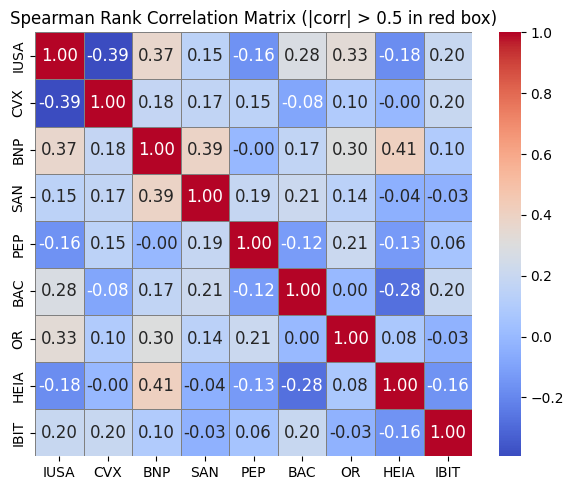

In [5]:
# Retriving data for correlation analysis

stock_hist_lnret_IUSA = Function.Calculate_daily_log_returns("IUSA.AS", start_date, end_date,"d")
stock_hist_lnret_CVX = Function.Calculate_daily_log_returns("CVX.US", start_date, end_date,"d")
stock_hist_lnret_BNP = Function.Calculate_daily_log_returns("BNP.PA", start_date, end_date,"d")
stock_hist_lnret_SAN = Function.Calculate_daily_log_returns("SAN.PA", start_date, end_date,"d")
stock_hist_lnret_PEP = Function.Calculate_daily_log_returns("PEP.US", start_date, end_date,"d")
stock_hist_lnret_BAC = Function.Calculate_daily_log_returns("BAC.US", start_date, end_date,"d")
stock_hist_lnret_OR = Function.Calculate_daily_log_returns("OR.PA", start_date, end_date,"d")
stock_hist_lnret_HEIA = Function.Calculate_daily_log_returns("HEIA.AS", start_date, end_date,"d")
stock_hist_lnret_IBIT = Function.Calculate_daily_log_returns("IBIT.US", start_date, end_date,"d")
    

# Create a Spearman rank correlation matrix for IUSA, CVX, BNP, and ADYN
# Merge all dataframes on 'date'
merged = stock_hist_lnret_IUSA[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'IUSA'})
merged = merged.merge(stock_hist_lnret_CVX[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'CVX'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_BNP[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'BNP'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_SAN[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'SAN'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_PEP[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'PEP'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_BAC[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'BAC'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_OR[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'OR'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_HEIA[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'HEIA'}), on='date', how='inner')
merged = merged.merge(stock_hist_lnret_IBIT[['date', 'daily_log_return']].rename(columns={'daily_log_return': 'IBIT'}), on='date', how='inner')

# Compute Spearman rank correlation matrix
corr_matrix_spearman = merged[['IUSA', 'CVX', 'BNP', 'SAN', 'PEP', 'BAC', 'OR', 'HEIA', 'IBIT']].corr(method='spearman')


# Plot Spearman rank correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
# Define a custom color map: values > 0.5 are red, others use the default
def custom_cmap(val, threshold=0.5):
    if val > threshold:
        return 'red'
    return 'white'

# Create a mask for values > 0.5 (absolute)
mask = corr_matrix_spearman.values > 0.5
# Plot heatmap with custom cell colors
sns.heatmap(
    corr_matrix_spearman,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 12}
)

# Overlay red boxes for values crossing threshold
for i in range(corr_matrix_spearman.shape[0]):
    for j in range(corr_matrix_spearman.shape[1]):
        if mask[i, j] and i != j:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))

plt.title("Spearman Rank Correlation Matrix (|corr| > 0.5 in red box)")
plt.tight_layout()
plt.show()

# Retriving value of stock

In [6]:
import datetime as dt
import time
from IPython.display import clear_output

Function = EODHD_Functions()

while True:
    clear_output(wait=True)

    stock_CVX = Function.Fetch_live_data('CVX.US')
    stock_BNP = Function.Fetch_live_data('BNP.PA')
    stock_SAN = Function.Fetch_live_data('SAN.PA')
    stock_PEP = Function.Fetch_live_data('PEP.US')
    stock_BAC = Function.Fetch_live_data('BAC.US')
    stock_OR = Function.Fetch_live_data('OR.PA')
    stock_HEIA = Function.Fetch_live_data('HEIA.AS')
    stock_IBIT = Function.Fetch_live_data('IBIT.US')

    # Extract close value and time
    close_CVX = stock_CVX['close'].iloc[0]
    time_CVX = stock_CVX['datetime'].iloc[0]

    close_BNP = stock_BNP['close'].iloc[0]
    time_BNP = stock_BNP['datetime'].iloc[0]

    close_SAN = stock_SAN['close'].iloc[0]
    time_SAN = stock_SAN['datetime'].iloc[0]

    close_PEP = stock_PEP['close'].iloc[0]
    time_PEP = stock_PEP['datetime'].iloc[0]

    close_BAC = stock_BAC['close'].iloc[0]
    time_BAC = stock_BAC['datetime'].iloc[0]

    close_OR = stock_OR['close'].iloc[0]
    time_OR = stock_OR['datetime'].iloc[0]

    close_HEIA = stock_HEIA['close'].iloc[0]
    time_HEIA = stock_HEIA['datetime'].iloc[0]

    close_IBIT = stock_IBIT['close'].iloc[0]
    time_IBIT = stock_IBIT['datetime'].iloc[0]

    # Decision logic for CVX.US
    if close_CVX > 160:
        status_CVX = "focus"
        if close_CVX > 162:
            status_CVX = "call ravi"
            if close_CVX < 152:
                status_CVX = "call ravi"
    else:
        status_CVX = "ok"

    # Decision logic for BNP.PA
    if close_BNP < 72:
        status_BNP = "call ravi"
    else:
        status_BNP = "ok"

      # Decision logic for SAN.PA
    if close_SAN < 78:
        status_SAN = "call ravi"
    else:
        status_SAN = "ok"

      # Decision logic for PEP.US
    if close_PEP < 135:
        status_PEP = "call ravi"
    else:
        status_PEP = "ok"

      # Decision logic for BAC.US
    if close_BAC < 45:
        status_BAC = "call ravi"
    else:
        status_BAC = "ok"

     # Decision logic for OR.PA
    if close_OR > 440:
        status_OR = "call ravi"
    else:
        status_OR = "ok"

    # Decision logic for HEIA.AS
    if close_HEIA < 65:
        status_HEIA = "call ravi"
    else:
        status_HEIA = "ok"

    # Decision logic for IBIT.US
    if close_IBIT < 55 or close_IBIT > 66:
        status_IBIT = "call ravi"
    else:
        status_IBIT = "ok"

    print(f" CVX.US Close: {close_CVX} (at {time_CVX}) [{status_CVX}]")
    print(f" BNP.PA Close: {close_BNP} (at {time_BNP}) [{status_BNP}]")
    print(f" SAN.PA Close: {close_SAN} (at {time_SAN}) [{status_SAN}] Not necessary")
    print(f" PEP.US Close: {close_PEP} (at {time_PEP}) [{status_PEP}] Not necessary")
    print(f" BAC.US Close: {close_BAC} (at {time_BAC}) [{status_BAC}]")
    print(f" OR.PA Close: {close_OR} (at {time_OR}) [{status_OR}]")
    print(f" HEIA.AS Close: {close_HEIA} (at {time_HEIA}) [{status_HEIA}]")
    print(f" IBIT.US Close: {close_IBIT} (at {time_IBIT}) [{status_IBIT}]")

    # Runs every 5 mins
    time.sleep(300)



 CVX.US Close: 155.02 (at 2025-11-07 21:07:00) [ok]
 BNP.PA Close: 65.49 (at 2025-11-07 16:38:00) [call ravi]
 SAN.PA Close: 85.44 (at 2025-11-07 16:38:00) [ok] Not necessary
 PEP.US Close: 142.95 (at 2025-11-07 21:00:00) [ok] Not necessary
 BAC.US Close: 53.2 (at 2025-11-07 21:18:00) [ok]
 OR.PA Close: 354.45 (at 2025-11-07 16:37:00) [ok]
 HEIA.AS Close: 69.8 (at 2025-11-07 16:36:00) [ok]
 IBIT.US Close: 58.88 (at 2025-11-07 21:29:00) [ok] Not necessary


KeyboardInterrupt: 

In [ ]:
import asyncio, websockets, json
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from matplotlib.dates import DateFormatter

URL = "wss://ws.eodhistoricaldata.com/ws/crypto?api_token={API_Eodhd}"

async def main(api_token):
    eth_data = []
    btc_data = []
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    try:
        async with websockets.connect(URL.format(API_Eodhd=api_token)) as ws:
            # Subscribe to both symbols
            await ws.send(json.dumps({"action":"subscribe","symbols":"ETH-USD,BTC-USD"}))
            while True:
                try:
                    msg = await ws.recv()
                    data = json.loads(msg)
                    if isinstance(data, dict) and "p" in data and "s" in data:
                        row = {
                            "price": float(data["p"]),
                            "time": pd.to_datetime(int(data["t"]), unit='ms') if "t" in data else pd.Timestamp.now()
                        }
                        
                        # Store data in appropriate list
                        if data["s"] == "ETH-USD":
                            eth_data.append(row)
                            df_eth = pd.DataFrame(eth_data[-100:])
                            # Update ETH plot
                            ax1.clear()
                            ax1.plot(df_eth['time'], df_eth['price'], '-b', linewidth=1)
                            ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))
                            ax1.tick_params(axis='x', rotation=45)
                            ax1.set_title(f"ETH-USD: ${df_eth['price'].iloc[-1]:.2f}", pad=15)
                            ax1.set_xlabel("Time")
                            ax1.set_ylabel("Price (USD)")
                            ax1.grid(True, linestyle='--', alpha=0.7)
                            
                        elif data["s"] == "BTC-USD":
                            btc_data.append(row)
                            df_btc = pd.DataFrame(btc_data[-100:])
                            # Update BTC plot
                            ax2.clear()
                            ax2.plot(df_btc['time'], df_btc['price'], '-r', linewidth=1)
                            ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
                            ax2.tick_params(axis='x', rotation=45)
                            ax2.set_title(f"BTC-USD: ${df_btc['price'].iloc[-1]:.2f}", pad=15)
                            ax2.set_xlabel("Time")
                            ax2.set_ylabel("Price (USD)")
                            ax2.grid(True, linestyle='--', alpha=0.7)
                        
                        # Display updated plots
                        clear_output(wait=True)
                        plt.tight_layout()
                        display(fig)
                        plt.pause(0.01)
                        
                except KeyboardInterrupt:
                    print("\nStopping...")
                    break
                except Exception as e:
                    continue
    finally:
        print("WebSocket connection closed")
        plt.close()

try:
    asyncio.get_event_loop().run_until_complete(main(API_Eodhd))
except KeyboardInterrupt:
    print("\nProgram stopped by user")

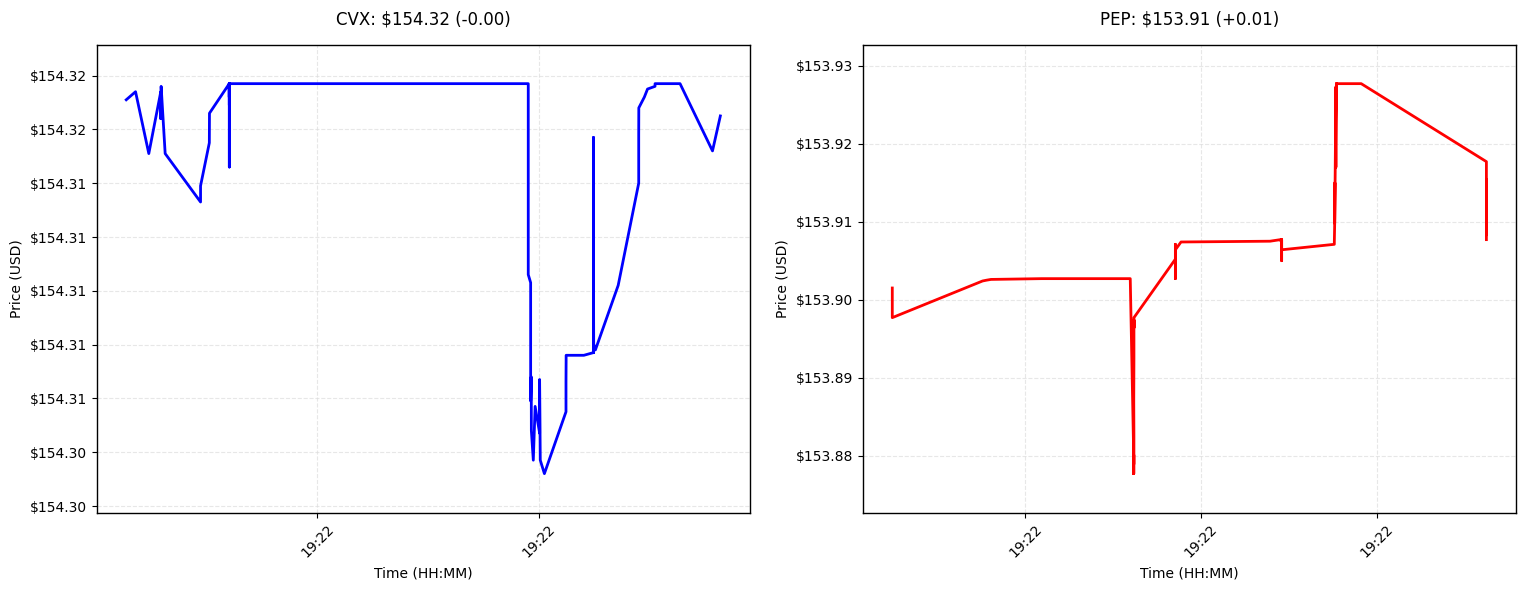

<Figure size 640x480 with 0 Axes>

In [ ]:
import asyncio, websockets, json
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter

URL = "wss://ws.eodhistoricaldata.com/ws/us?api_token={API_Eodhd}"

async def main(api_token):
    cvx_data = []
    pep_data = []
    plt.ion()
    
    # Create figure with white background and enhanced style
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.grid': True,
        'grid.color': '#dddddd',
        'axes.linewidth': 1.0,
        'font.size': 10
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    try:
        async with websockets.connect(URL.format(API_Eodhd=api_token)) as ws:
            await ws.send(json.dumps({"action":"subscribe","symbols":"CVX,PEP"}))
            while True:
                try:
                    msg = await ws.recv()
                    data = json.loads(msg)
                    if isinstance(data, dict) and "p" in data and "s" in data:
                        row = {
                            "price": float(data["p"]),
                            "time": pd.to_datetime(int(data["t"]), unit='ms') if "t" in data else pd.Timestamp.now()
                        }
                        
                        if data["s"] == "CVX":
                            cvx_data.append(row)
                            df_cvx = pd.DataFrame(cvx_data[-100:])
                            ax1.clear()
                            ax1.plot(df_cvx['time'], df_cvx['price'], '-b', linewidth=2)
                            
                            # Formatting
                            ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))
                            ax1.yaxis.set_major_formatter(FormatStrFormatter('$%.2f'))
                            ax1.tick_params(axis='both', which='major', labelsize=10)
                            ax1.tick_params(axis='x', rotation=45)
                            
                            # Dynamic y-axis
                            if len(df_cvx) > 1:
                                price_range = df_cvx['price'].max() - df_cvx['price'].min()
                                y_min = df_cvx['price'].min() - price_range * 0.1
                                y_max = df_cvx['price'].max() + price_range * 0.1
                                ax1.set_ylim(y_min, y_max)
                            
                            current_price = df_cvx['price'].iloc[-1]
                            price_change = current_price - df_cvx['price'].iloc[0]
                            ax1.set_title(f"CVX: ${current_price:.2f} ({price_change:+.2f})", pad=15)
                            ax1.set_xlabel("Time (HH:MM)")
                            ax1.set_ylabel("Price (USD)")
                            ax1.grid(True, linestyle='--', alpha=0.7)

                        elif data["s"] == "PEP":
                            pep_data.append(row)
                            df_pep = pd.DataFrame(pep_data[-100:])
                            ax2.clear()
                            ax2.plot(df_pep['time'], df_pep['price'], '-r', linewidth=2)
                            
                            # Formatting
                            ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
                            ax2.yaxis.set_major_formatter(FormatStrFormatter('$%.2f'))
                            ax2.tick_params(axis='both', which='major', labelsize=10)
                            ax2.tick_params(axis='x', rotation=45)
                            
                            # Dynamic y-axis
                            if len(df_pep) > 1:
                                price_range = df_pep['price'].max() - df_pep['price'].min()
                                y_min = df_pep['price'].min() - price_range * 0.1
                                y_max = df_pep['price'].max() + price_range * 0.1
                                ax2.set_ylim(y_min, y_max)
                            
                            current_price = df_pep['price'].iloc[-1]
                            price_change = current_price - df_pep['price'].iloc[0]
                            ax2.set_title(f"PEP: ${current_price:.2f} ({price_change:+.2f})", pad=15)
                            ax2.set_xlabel("Time (HH:MM)")
                            ax2.set_ylabel("Price (USD)")
                            ax2.grid(True, linestyle='--', alpha=0.7)
                        
                        # Display updated plots
                        clear_output(wait=True)
                        plt.tight_layout()
                        display(fig)
                        plt.pause(0.01)
                        
                except KeyboardInterrupt:
                    print("\nStopping...")
                    break
                except Exception as e:
                    continue
    finally:
        print("WebSocket connection closed")
        plt.close()

# Handle both Jupyter and regular Python environments
try:
    loop = asyncio.get_event_loop()
    if loop.is_running():
        await main(API_Eodhd)
    else:
        loop.run_until_complete(main(API_Eodhd))
except KeyboardInterrupt:
    print("\nProgram stopped by user")